In [1]:
# plot_seaice_spectra_forpaper
#
# Steven Cavallo
# December 2024
###########################
# imports
###########################
import matplotlib.pyplot as plt
import numpy as np
import sys, imp
import pylab
import datetime as dt
import os, datetime
import csv
import pandas as pd
import xarray as xr
from scipy.fftpack import fft
from scipy.signal import blackman, butter, lfilter, filtfilt, freqz, periodogram
import matplotlib.patches as patches
import pickle

import weather_modules as wm
import utilities_modules as um
import spectral_utilities as su

from mstats import *

/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_33318/502879128.py:10: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, imp


In [2]:
blackmann = 'True'
standardize_option = 'False'
remove_annual_cycle = 'False'
remove_annual_cycle_rednoise = 'False'

cutoff_period = 18
number_days_dextent = 3 
year_range = [1989,2022]

fpath = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/N_seaice_extent_daily_v3.0_1979_2023.csv'
fpath_cesm_mem1 = 'iceextent_nh_b.e11.B20TRC5CNBDRD.f09_g16.002.txt'
fpath_cesm_mem2 = 'iceextent_nh_b.e11.BRCP85C5CNBDRD.f09_g16.002.txt'
imagedir = '/Users/scavallo/Documents/scripts/python_scripts/images/'
label_fontsize = 18

In [3]:
file = open(fpath, 'r')
data = np.loadtxt(file,skiprows=2, delimiter=',',usecols=(0,1,2,3))
years = data[:,0].astype(int) #e.g., 1981
months = data[:,1].astype(int) #e.g., 01
days=data[:,2].astype(int) #e.g., 01
extents = data[:,3] #e.g., 11.345 [10^6km^2]   

#convert individual yr,month,day to time values
nVals = len(extents)
print(nVals)
timeList = [dt.datetime(years[i],months[i],days[i]) for i in range(nVals)]; timeList = np.array(timeList)
  
# interpolate to uniform time grid ("daily" values early on are every 2 days)
tStart = timeList[0]; tEnd = timeList[-1]
nDays = (tEnd-tStart).total_seconds()/(24*3600); nDays = int(nDays)
print('{0} days between {1} {2}'.format(nDays, tStart, tEnd))
times = [tStart+ dt.timedelta(days=i) for i in range(0, nDays)]; times = np.array(times)
  
dTime = [(a-timeList[0]).total_seconds() for a in timeList]
dTimeResample = [(a-timeList[0]).total_seconds() for a in times]
extents = np.interp(dTimeResample, dTime, extents)    
    
del years, months, days
years = [i.year for i in times]
months = [i.month for i in times]
days = [i.day for i in times]
    
years = np.array(years)
months = np.array(months)
days = np.array(days)

[inds] = np.where( (years>=year_range[0]) & (years<=year_range[-1]) )

timefocus = times[inds]
yearfocus = years[inds]
monthfocus = months[inds]
dayfocus = days[inds]
extentfocus = extents[inds]

dextent = np.zeros_like(extentfocus).astype('f')
z0 = np.zeros_like(extentfocus).astype('f')
dextent[0:-1] = extentfocus[1:] - extentfocus[0:-1]
dextent[len(dextent)-1] = dextent[0]

ndays = number_days_dextent
dextent_int = np.zeros_like(extentfocus).astype('f')
for ii in range(ndays,len(dextent_int)):
    sind = ii-ndays+1
    eind = sind+ndays
    dextent_int[ii] = np.nansum(dextent[sind:eind])
dextent_int[0:ndays] = dextent_int[ndays] 
dextent_int[len(dextent_int)-1] = dextent_int[0]

14852
16502 days between 1978-10-26 00:00:00 2023-12-31 00:00:00


In [4]:
time_step = 24.0*3600.0
t = np.arange(0,len(extentfocus),1)  

dataspec = extentfocus
dataspec2 = dextent_int

In [5]:
file1 = open(fpath_cesm_mem1,"r")
tmp1 = [float(line) for line in file1.readlines()] 
file1.close()

file2 = open(fpath_cesm_mem2,"r")
tmp2 = [float(line) for line in file2.readlines()] 
file2.close()

le=tmp1+tmp2

dr = pd.date_range(start='1/1/1920', end='12/31/2080', freq='D')
dates = dr[(dr.day != 29) | (dr.month != 2)]

da_le= xr.DataArray(le, dims='time', coords={'time':dates})   
da_le.name = 'Extent'
da_le=da_le.sel(time=slice('1989-01-01','2018-12-31'))
le=da_le.to_dataset()

tmp=le.Extent.values

dExt = np.zeros_like(tmp).astype('f')

dExt[0:-1] = tmp[1:] - tmp[0:-1]
dExt[len(dExt)-1] = dExt[0]

ndays = number_days_dextent
dExt_int = np.zeros_like(tmp).astype('f')
for ii in range(ndays,len(dExt_int)):
    sind = ii-ndays+1
    eind = sind+ndays
    dExt_int[ii] = np.nansum(dExt[sind:eind])
    dExt_int[0:ndays] = dExt_int[ndays] 
dExt_int[len(dExt_int)-1] = dExt_int[0]
dExt=xr.DataArray(dExt_int, dims='time', coords={'time':le.time}) 
dExt.name = 'dExt'
le = xr.merge([le, dExt])

cesm_extent = np.array(le.Extent)
cesm_dextent = np.array(le.dExt)

In [6]:
N = np.size(dataspec) # Sample size
N = int(N)
Nover2 = int(np.floor(N/2))

N2 = np.size(dataspec2) # Sample size
N2 = int(N2)
N2over2 = int(np.floor(N2/2))

sample_freq = 1/time_step

xf = np.linspace(0.0,1.0/(2.0*time_step),Nover2)
xt = (1.0/xf)/(3600.0*24.0) # Period in Days


dataspec_noann = np.zeros_like(dataspec).astype('f')
dataspec2_noann = np.zeros_like(dataspec2).astype('f')
dataspec_cesm_noann = np.zeros_like(cesm_extent).astype('f')
dataspec2_cesm_noann = np.zeros_like(cesm_dextent).astype('f')
for i in range(365, len(dataspec)):
    dataspec_noann[i] = dataspec[i] - dataspec[i - 365]
    dataspec2_noann[i] = dataspec2[i] - dataspec2[i - 365]
    
for i in range(365, len(cesm_extent)):   
    dataspec_cesm_noann[i] = cesm_extent[i] - cesm_extent[i - 365]
    dataspec2_cesm_noann[i] = cesm_dextent[i] - cesm_dextent[i - 365]

if remove_annual_cycle == 'True': 
    del dataspec, dataspec2, cesm_extent, cesm_dextent
    dataspec = dataspec_noann
    dataspec2 = dataspec2_noann
    cesm_extent = dataspec_cesm_noann
    cesm_dextent = dataspec2_cesm_noann
    
# If you subtract the mean and divide by the standard deviation, the power spectral density has units of variance/Hz.
if standardize_option == 'True':
    datam = (dataspec - np.nanmean(dataspec)) / np.std(dataspec)
    datam2 = (dataspec2 - np.nanmean(dataspec2)) / np.std(dataspec2)
    
    datam_cesm = (cesm_extent - np.nanmean(cesm_extent)) / np.std(cesm_extent)
    datam_cesm2 = (cesm_dextent - np.nanmean(cesm_dextent)) / np.std(cesm_dextent)    
else:
    # If you only subtract the mean, the power spectral density will have units of dataspec**2/Hz
    datam = (dataspec - np.nanmean(dataspec))  
    datam2 = (dataspec2 - np.nanmean(dataspec2)) 
    
    datam_cesm = (cesm_extent - np.nanmean(cesm_extent))
    datam_cesm2 = (cesm_dextent - np.nanmean(cesm_dextent))    
    

# Do the CESM calculations
Ncesm = int(len(datam_cesm))
Ncesm2 = int(np.floor(Ncesm/2))
if blackmann == 'True':
    wcesm = blackman(Ncesm)
    wcesm2 = blackman(Ncesm2)
else:
    wcesm = np.ones_like(Ncesm)
    wcesm2 = np.ones_like(Ncesm2)

ypow_cesm = np.abs(np.fft.rfft(datam_cesm*wcesm))**2.0
yplot_cesm = 2.0/Ncesm*np.abs(ypow_cesm[0:Ncesm2])*time_step
xf_cesm = np.linspace(0.0,1.0/(2.0*time_step),Ncesm2)
xt_cesm = (1.0/xf_cesm)/(3600.0*24.0) # Period in Days

ypow_cesm2 = np.abs(np.fft.rfft(datam_cesm2*wcesm))**2.0
yplot_cesm2 = 2.0/Ncesm*np.abs(ypow_cesm2[0:Ncesm2])*time_step

/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_33318/3235111912.py:12: RuntimeWarning: divide by zero encountered in divide
  xt = (1.0/xf)/(3600.0*24.0) # Period in Days
/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_33318/3235111912.py:54: DeprecationWarning: Importing blackman from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackman' or the convenience function 'scipy.signal.get_window' instead.
  wcesm = blackman(Ncesm)
/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_33318/3235111912.py:55: DeprecationWarning: Importing blackman from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackman' or the convenience function 'scipy.signal.get_window' instead.
  wcesm2 = blackman(Ncesm2)
/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_33318/3235111912.py:63: RuntimeWarning: divide by zero encountered in divide
  xt_cesm = (1.0/xf_c

In [7]:
rate = sample_freq
overlap = len(dataspec)
w3 = np.ones_like(N)
w4 = np.ones_like(N2)    

yout1=su.get_power_spectral_density(datam*w3, rate, nfft=overlap, noverlap=None)
yout2=su.get_power_spectral_density(datam2*w4, rate, nfft=overlap, noverlap=None)
    
yplot3 = yout1[1][:]
yplot4 = yout2[1][:]
freq = yout1[0][:]
xt2 = (1./freq)/(24.*3600.)

/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_33318/2943826267.py:12: RuntimeWarning: divide by zero encountered in divide
  xt2 = (1./freq)/(24.*3600.)


In [8]:
# Red noise spectrum
conf = 95
chunk_length = 2 # days
     
rrr = um.autocorr(datam,5) 
rr = rrr[1] # 1 time-step autocorrelation    
print('The one time-step autocorrelation is %7.4f' %(rrr[1]))
print(rrr)
print(len(datam)/2,len(xf))
 
if remove_annual_cycle_rednoise == 'True':
    datain_red = dataspec_noann
else:
    datain_red = datam
ypow_red, ypow_red_sig, redfacs = um.red_noise_spectrum(datain_red,conf,chunk_length,rr)
# Need to scale, since data are separated by one day (Units are currently Power/day-1) and we need Power/s-1)
yplot_red = ypow_red_sig[0:Nover2]*time_step

rrr2 = um.autocorr(datam2,5) 
rr2 = rrr2[1] # 1 time-step autocorrelation    
print('The one time-step autocorrelation is %7.4f' %(rrr2[1]))
print(rrr2)
     
if remove_annual_cycle_rednoise == 'True':
    datain_red2 = dataspec2_noann
else:
    datain_red2 = datam2
ypow_red2, ypow_red_sig2, redfacs2 = um.red_noise_spectrum(datain_red2,conf,chunk_length,rr2)
# Need to scale, since data are separated by one day (Units are currently Power/day-1) and we need Power/s-1)
yplot_red2 = ypow_red_sig2[0:Nover2]*time_step    

The one time-step autocorrelation is  0.9997
[1.0, 0.9996910687927394, 0.9990349830018677, 0.9980601191394947, 0.9967638011880002]
6209.0 6209
Degrees of freedom for red noise test is 12418.00
The one time-step autocorrelation is  0.9236
[1.0, 0.9235918, 0.8344295, 0.7547558, 0.75101674]
Degrees of freedom for red noise test is 12418.00


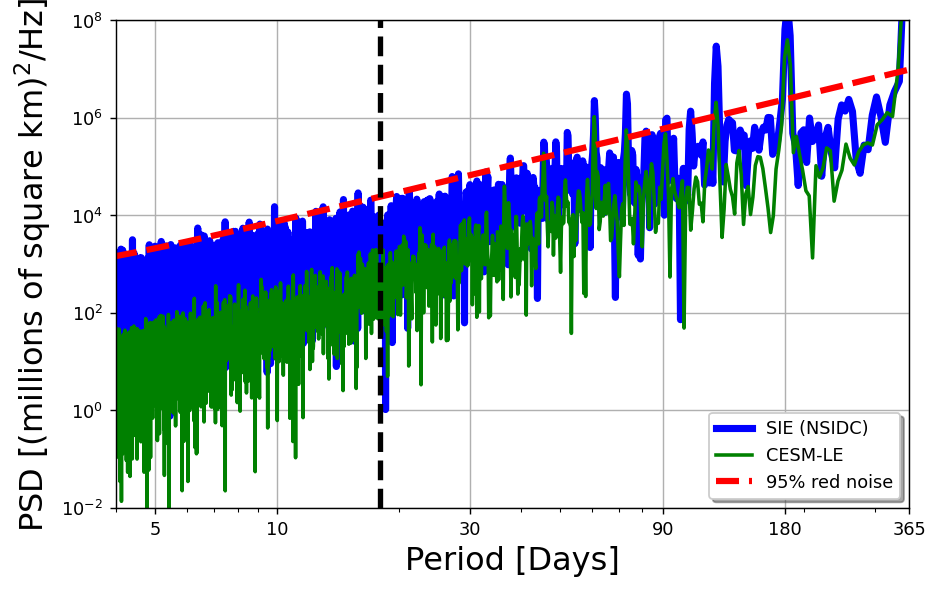

In [9]:
xticks = [5,10,30,90,180,365]

golden = (pylab.sqrt(5)+1.)/2.
figprops = dict(figsize=(8., 8./ golden ), dpi=128)    # Figure properties for single and stacked plots
adjustprops = dict(left=0.15, bottom=0.1, right=0.90, top=0.93, wspace=0.2, hspace=0.2) 

fig = pylab.figure(**figprops)   # New figure
ax1 = fig.add_subplot(1, 1, 1)

plt.loglog(xt2,yplot3,'b',linewidth=4.0,label=r'SIE (NSIDC)')
plt.loglog(xt_cesm,yplot_cesm,'g',linewidth=2.0,label='CESM-LE')   
plt.loglog(xt,yplot_red,'r--',linewidth=3.5,label='95% red noise')

legend = ax1.legend(loc='lower right', shadow=True)
ax1.grid(True, linestyle='-')
ax1.set_xlim(4,365)

plt.axvline(x=18,color='k', linestyle='--',linewidth=3.0)

ax1.set_ylim(10**-2,10**8)
ax1.xaxis.set_ticks(xticks)
ax1.set_xticklabels(xticks)

ax1.set_ylabel(r'PSD [(millions of square km)$^2$/Hz]',fontsize=label_fontsize)
ax1.set_xlabel('Period [Days]',fontsize=label_fontsize)
save_name = imagedir + 'SIE_spectra_withCESM' + '.png'
plt.savefig(save_name, bbox_inches='tight')
#plt.show()

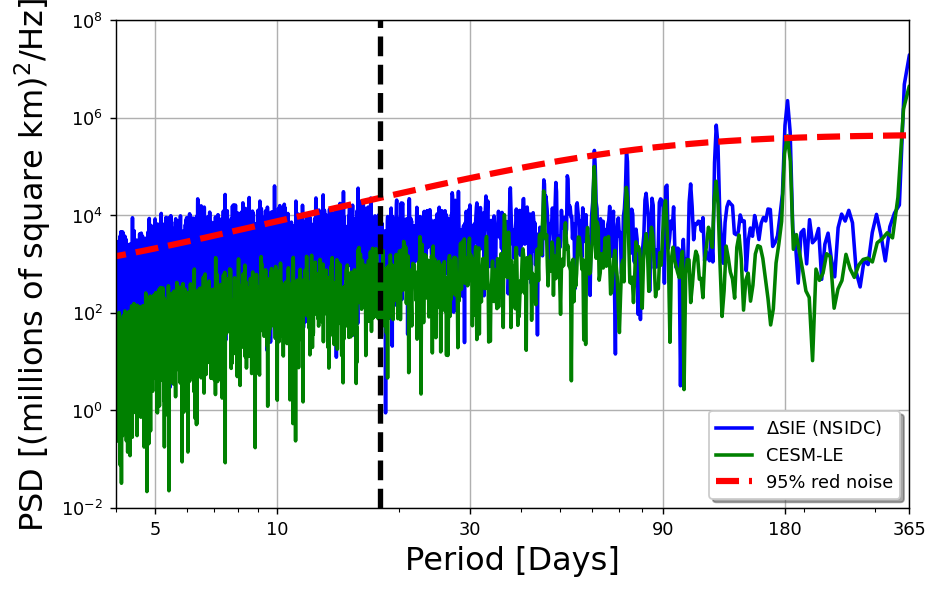

In [10]:
golden = (pylab.sqrt(5)+1.)/2.
figprops = dict(figsize=(8., 8./ golden ), dpi=128)    # Figure properties for single and stacked plots
adjustprops = dict(left=0.15, bottom=0.1, right=0.90, top=0.93, wspace=0.2, hspace=0.2) 

fig = pylab.figure(**figprops)   # New figure
ax1 = fig.add_subplot(1, 1, 1)

plt.loglog(xt2,yplot4,'b',linewidth=2.0,label=r'$\Delta$SIE (NSIDC)')
plt.loglog(xt_cesm,yplot_cesm2,'g',linewidth=2.0,label='CESM-LE')
plt.loglog(xt,yplot_red2,'r--',linewidth=3.5,label='95% red noise')

legend = ax1.legend(loc='lower right', shadow=True)
ax1.grid(True, linestyle='-')
ax1.set_xlim(4,365)

plt.axvline(x=18,color='k', linestyle='--',linewidth=3.0)

ax1.set_ylim(10**-2,10**8)
ax1.xaxis.set_ticks(xticks)
ax1.set_xticklabels(xticks)

ax1.set_ylabel(r'PSD [(millions of square km)$^2$/Hz]',fontsize=label_fontsize)
ax1.set_xlabel('Period [Days]',fontsize=label_fontsize)

save_name = imagedir + 'DeltaSIE_spectra_withCESM' + '.png'
plt.savefig(save_name, bbox_inches='tight')
plt.show()